In [ ]:
pip install datasets transformers

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import list_datasets, load_dataset
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Let's observe the first 10 datasets on datasets library
datasets_list = list_datasets()
print(f"There are {len(datasets_list)} datasets currently available on the Hub.")
print(f"The first 10 are: {datasets_list[:10]}")

There are 1216 datasets currently available on the Hub.
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
# AG_news dataset is the dataset on which we'll be finetunning our model
dataset_name = 'ag_news'
AG_news_dataset = load_dataset(dataset_name)
AG_news_dataset

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/751k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [5]:
# Let's observe the dataset in the standard pandas dataframe format
AG_news_dataset.set_format(type="pandas")
df = AG_news_dataset["train"][:]
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [6]:
# We'll add the class name for its label index
def label_int2str(row, split):
    return AG_news_dataset[split].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


Text(0.5, 1.0, 'Category Counts')

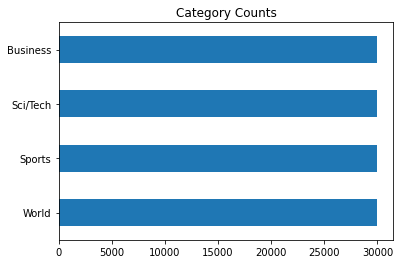

In [7]:
# Distribution of training news texts per class (Balanced)
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts")

Text(0.5, 0, '')

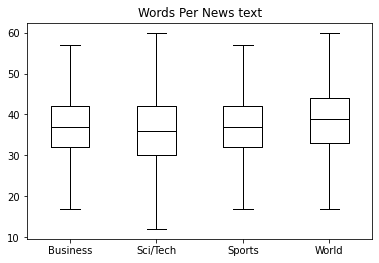

In [8]:
df["Words Per News text"] = df["text"].str.split().apply(len)
df.boxplot("Words Per News text", by='label_name', grid=False, showfliers=False,
           color='black', )
plt.suptitle("")
plt.xlabel("")

In [9]:
# we'll take 8000 samples for training and 2000 for evaluating
AG_news_dataset_train = load_dataset(dataset_name, split='train[:8000]')
AG_news_dataset_validation = load_dataset(dataset_name, split='train[-2000:]')

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


In [10]:
# We'll use distilbert model (lighweight version of BERT)
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Let's tokenize the training and evaluating datasets
AG_news_dataset_encoded_train = AG_news_dataset_train.map(tokenize, batched=True, batch_size=None)
AG_news_dataset_encoded_validation = AG_news_dataset_validation.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
# Set the datasets attributes (input_ids attention_mask and label) to pytorch tensors to be mainpulated by the model
AG_news_dataset_encoded_train.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
AG_news_dataset_encoded_validation.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [13]:
# Define the classification model with 4 classes
num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [14]:
# Define the metrics to be used in the training process
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
batch_size = 32
# Defining the training arguments
logging_steps = len(AG_news_dataset_encoded_train['text']) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps", # not epochs
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,)

# Initialize the Trainer class
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=AG_news_dataset_encoded_train,
                  eval_dataset=AG_news_dataset_encoded_validation)

# Start the training
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 8000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Step,Training Loss,Validation Loss,Accuracy,F1
250,0.491100,0.298977,0.895500,0.896148
500,0.270800,0.272284,0.905500,0.906291


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to results/checkpoint-250
Configuration saved in results/checkpoint-250/config.json
Model weights saved in results/checkpoint-250/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-500 (score: 0.9062914484965869).


TrainOutput(global_step=500, training_loss=0.3809671630859375, metrics={'train_runtime': 1024.6551, 'train_samples_per_second': 15.615, 'train_steps_per_second': 0.488, 'total_flos': 1415795818752000.0, 'train_loss': 0.3809671630859375, 'epoch': 2.0})

In [16]:
results = trainer.evaluate()
results

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 2.0,
 'eval_accuracy': 0.9055,
 'eval_f1': 0.9062914484965869,
 'eval_loss': 0.27228403091430664,
 'eval_runtime': 42.1853,
 'eval_samples_per_second': 47.41,
 'eval_steps_per_second': 1.493}

In [17]:
preds_output = trainer.predict(AG_news_dataset_encoded_validation)
preds_output.metrics

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


{'test_accuracy': 0.9055,
 'test_f1': 0.9062914484965869,
 'test_loss': 0.27228403091430664,
 'test_runtime': 42.1388,
 'test_samples_per_second': 47.462,
 'test_steps_per_second': 1.495}

In [18]:
# Visualize the classification report
labels = ['World', 'Sports', 'Business', 'Sci/Tech']
print(classification_report(np.array(AG_news_dataset_encoded_validation['label']), 
                            preds_output.predictions.argmax(1), 
                            target_names=labels))

              precision    recall  f1-score   support

       World       0.95      0.88      0.91       484
      Sports       0.98      0.98      0.98       521
    Business       0.91      0.83      0.87       537
    Sci/Tech       0.79      0.94      0.86       458

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [19]:
# Let's predict on an unseen text from news in the web 
custom_news = """When Channel 4’s coverage of the Paralympics begins on Tuesday viewers will be spoilt for choice, 
                 with more than 1,300 hours of events on offer, almost triple the coverage of the home Games in London 2012, 
                 and the broadcaster turning over its flagship channel to the Olympics for a staggering 17.5 hours each day."""
input_tensor = tokenizer.encode(custom_news, return_tensors="pt").to("cuda")
logits = model(input_tensor).logits
logits

tensor([[ 0.0753,  1.4061, -1.3687, -0.1637]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [20]:
# Compute probability from logits (classification model output)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()
probs

array([0.17218947, 0.65158546, 0.04063467, 0.13559042], dtype=float32)

Text(0, 0.5, 'Class probability (%)')

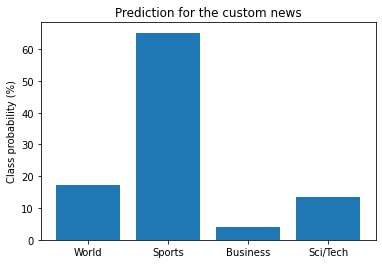

In [22]:
# Visualize the probability of each class
plt.bar(labels, 100 * probs, color='C0')
plt.title("Prediction for the custom news")
plt.ylabel("Class probability (%)")